In [142]:
#import tensorboard
#%load_ext tensorboard
#%tensorboard --logdir 'logs/'
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import KFold
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input, Dropout
from keras import regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import PolynomialFeatures
from keras.regularizers import l2, l1

In [143]:
df = pd.read_csv('diabetes.csv')

In [144]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [145]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


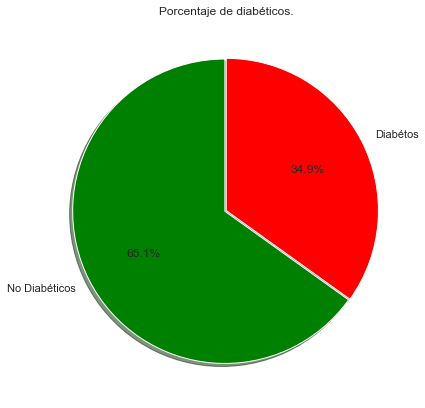

In [146]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [147]:
df2 = df.copy()
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

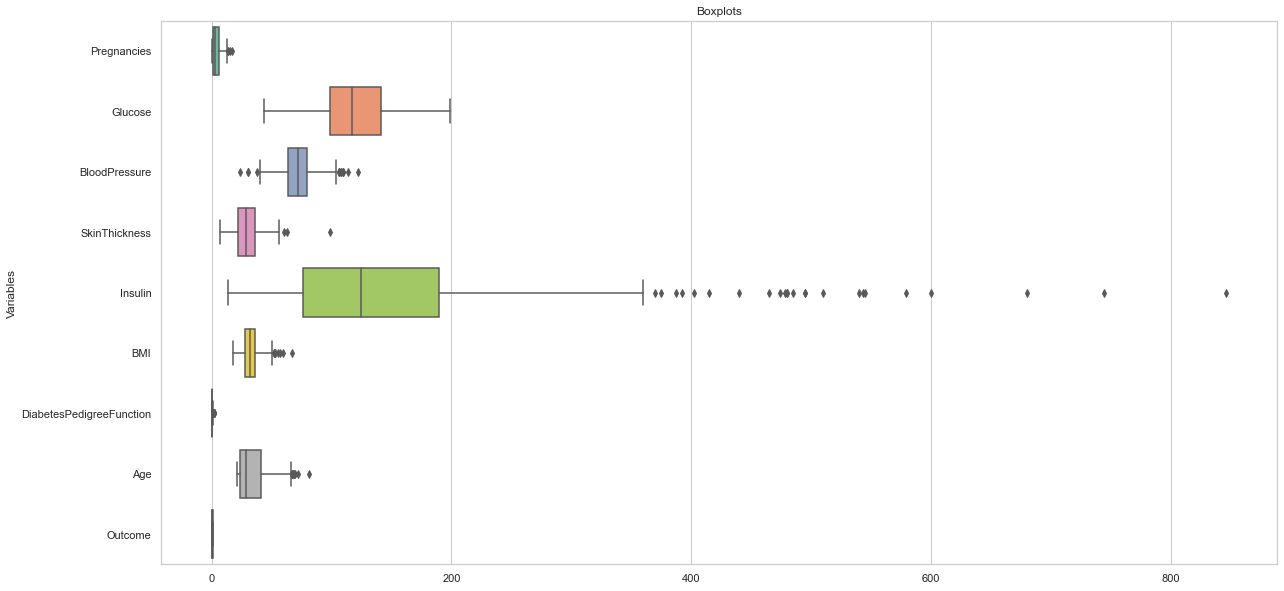

In [148]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots")
ax = sns.boxplot(data = df2, 
  orient = 'h', 
  palette = 'Set2')

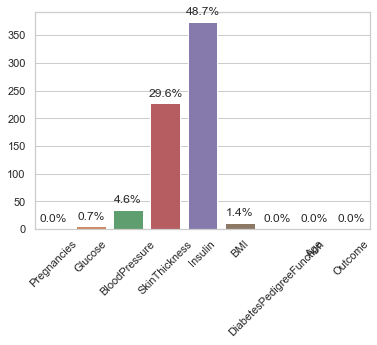

In [149]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df2.columns, y=df2.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [150]:
correlations = df2.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [151]:
df = df.drop(['Insulin'], axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1


In [152]:
 def separate_data_and_labels(df):
        data = df.copy()
        y_values = data[data.columns[-1]].values.reshape(data.shape[0], 1)
        data = data.drop([data.columns[-1]], axis=1)
        return data, y_values

In [153]:
np.random.seed(0)
msk = np.random.rand(len(df)) < 0.8
train_val_df = df[msk]
testData = df[~msk]

train_val_data , y_train_val = separate_data_and_labels(train_val_df)
x_test_data, y_test_values = separate_data_and_labels(testData)

In [154]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [155]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')
    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')
    # X-axis label.
    plt.xlabel('Epochs')
    # Y-axis label.
    plt.ylabel('Cost')
    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])
    # Graph title.
    plt.title('Loss Graph')
    plt.show()

In [156]:
class DiabetesPredictor:
    def __init__(self, name):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.

    """
        self.name = name

    def fit(self, train_df, y_train, val_df, y_val, replaceOutliers=False, replaceNulls=False, nullColumns=[], outliersColumnsMap={}, columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1, earlyStop = False, dropOut = False, regu = False, batchNormalization = False):
        train_dataframe = train_df.copy()

        self.columnsToRemove = columnsToRemove.copy()
        self.nullCols = nullColumns.copy()
        self.replaceNulls = replaceNulls
        self.replaceOutliers = replaceOutliers
        self.polyFeatDeg = polyFeatDeg
        self.binsDiscretizer = binsDiscretizer
        self.earlyStop = earlyStop
        self.dropOut = dropOut
        self.regu = regu
        self.best_hps = None
        self.batchNormalization = batchNormalization

        self.replace_values_nulls = []
        self.replace_values_outliers = []
        self.outliersLimits = []
        self.history = None

        self.nullCols = [n for n in self.nullCols if n not in self.columnsToRemove]
        self.outlierCols = {}
        for k in outliersColumnsMap:
            if k not in self.columnsToRemove:
                self.outlierCols[k] = outliersColumnsMap[k].copy()

        train_dataframe = self.__preprocess_data__(train_dataframe, training=True)

        x_train_values = train_dataframe.values
        y_train_values = y_train.copy()

        self.input_shape = x_train_values.shape

        x_val_df = val_df.copy()
        x_val_df = self.__preprocess_data__(x_val_df)
        x_val_values = x_val_df.values
        y_val_values = y_val.copy()

        self.hypermodel = self.__tune_hyperparams__(x_train_values, y_train_values, x_val_values,y_val_values)

        self.auc, self.spe, self.sen, self.ppv, self.npv, self.fpr, self.tpr = self.evaluate(x_val_df, y_val_values, testing = False)
        
    def __preprocess_data__(self, data, training = False):
        df = data.copy()
        df = self.__remove_columns__(df)

        if self.replaceNulls:
            df[self.nullCols] = df[self.nullCols].replace(0,np.NaN)

        if training:
            self.replace_values_outliers = self.__get_cols_median__(df)
            self.outliersLimits = self.__get_outliers_limits__(df)

        if(self.replaceOutliers):
            df = self.__replace_outliers__(df)

        if training:
            self.replace_values_nulls = self.__get_cols_median__(df)

        if(self.replaceNulls):
            df = self.__replace_nulls__(df)

        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            polyArray = poly.fit_transform(df)
            c = poly.get_feature_names(df.columns)
            df = pd.DataFrame(polyArray, columns = c)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            df = disc.fit_transform(df)

        if training:
            self.mean_cols = self.__get_cols_mean__(df)
            self.std_cols = self.__get_cols_std__(df)

        df = self.__normalize_data__(df)

        return df

    def __get_cols_mean__(self, data):
        meandf = data.mean(axis = 0)
        meandf.columns = data.columns
        return meandf

    def __get_cols_std__(self, data):
        stddf= data.std(axis = 0)
        stddf.columns = data.columns
        return stddf

    def __get_cols_median__(self, data):
        mediandf = data.median(axis = 0)
        mediandf.columns = data.columns
        return mediandf

    def __get_outliers_limits__(self, data):
        df = pd.DataFrame(np.zeros((1,len(data.columns))), columns=data.columns)
        df = df.astype('object')
        for col in data.columns:
            col_min = 0
            col_max = np.Infinity
            if (col in self.outlierCols):
                #Cálculo de parámetros para obtener los outliers.
                q1 = data[col].quantile(0.25)
                q3 = data[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                lower_tail = q1 - 1.5 * iqr
                upper_tail = q3 + 1.5 * iqr

                col_min = min(lower_tail, self.outlierCols[col][0])
                col_max = max(upper_tail,self.outlierCols[col][1])
            lims = [col_min, col_max]
            df[col][0] = lims
        return df

    def __replace_outliers__(self, dataframe):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        df = dataframe.copy()
        for col in df.columns:
            out_min = self.outliersLimits[col][0][0]
            out_max = self.outliersLimits[col][0][1]
            for i in df[col]:
                if i > out_max or i < out_min:
                    df[col] = df[col].replace(i, self.replace_values_outliers[col])
        return df

    def __replace_nulls__(self, dataframe):
        df = dataframe.copy()
        for col in self.nullCols:
            df[col]=df[col].replace(np.NaN, self.replace_values_nulls[col])
        return df

    def __normalize_data__(self, dataframe):
        # Mean, columnar axis.
        df = dataframe.copy()
        for col in df.columns:
            if (self.std_cols[col] != 0):
                df[col] = (df[col] - self.mean_cols[col]) / self.std_cols[col]
            else:
                df[col] = 0
        return df

    def __remove_columns__(self, dataframe):
        df = dataframe.copy()
        df = df.drop(self.columnsToRemove, axis=1)
        return df

    def __model_builder__(self,hp):
        model = Sequential()
        initializer = tf.keras.initializers.GlorotNormal(seed=7)

        if(self.dropOut):
            model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5),input_shape=(self.input_shape[1],)))
            model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
        elif(self.regu):
            reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', [0.01,0.001,0.1,0.005,0.05]))
            model.add(Dense(1, kernel_initializer=initializer,kernel_regularizer=reg, activation='sigmoid', input_shape=(self.input_shape[1],)))
        elif (self.batchNormalization):
            model.add(BatchNormalization(input_shape=(self.input_shape[1],)))
            model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
        else:
            model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', input_shape=(self.input_shape[1],)))

        
        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        #hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate= hp.Float(
            'learning_rate',
            min_value=1e-5,
            max_value=1e-2,
            sampling='LOG',
            default=1e-3
        )
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_decay = hp.Float('decay', 1e-5, 1e-3, sampling='log', default=1e-4)

        model.compile(optimizer=optimizers.SGD(learning_rate=hp_learning_rate, momentum=hp_momentum, decay = hp_decay),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])
        return model

    def __tune_hyperparams__(self, x_train, y_train, x_val, y_val):
        # log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")
        # hist_callback = tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir,
        #     histogram_freq=1,
        #     embeddings_freq=1,
        #     write_graph=True,
        #     update_freq='batch')
        tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     seed = 4,
                     executions_per_trial=3,
                     project_name=self.name,
                     directory='saved_models'
                     )
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

        #### Search for HyperParams #####
        if (self.earlyStop):
            tuner.search(x_train, y_train, epochs=125, validation_data = (x_val, y_val), callbacks=[stop_early], use_multiprocessing=True, verbose=2)
        else:
            tuner.search(x_train, y_train, epochs=125, validation_data = (x_val, y_val), use_multiprocessing=True, verbose=2)

        # Get the optimal hyperparameters
        self.best_hps = tuner.get_best_hyperparameters()[0]

        # Build the model with the optimal hyperparameters and train it on the data
        model = tuner.hypermodel.build(self.best_hps)
        if (self.earlyStop):
            history = model.fit(x_train, y_train, epochs=125, validation_data = (x_val, y_val),callbacks=[stop_early], verbose=0)
        else:
            history = model.fit(x_train, y_train, epochs=125, validation_data = (x_val, y_val), verbose=0)

        self.history = history
        # Plot Loss
        plot_loss(history)

        # Find optimal Epocs
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1

        # Build and Retrain the model with best Epochs
        hypermodel = tuner.hypermodel.build(self.best_hps)
        if (self.earlyStop):
            hypermodel.fit(x_train, y_train, epochs=best_epoch,callbacks=[stop_early], validation_data = (x_val, y_val), verbose=0)
        else:
            hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_data = (x_val, y_val), verbose=0)

        # Return trained model
        return hypermodel

    def evaluate(self, x_val_df, y_val, testing=True):
        x_df = x_val_df.copy()
        predictions, rounded_preds = self.predict(x_df, testing=testing)

        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, predictions)
        auc_keras = auc(fpr_keras, tpr_keras)
        spe = specificity(y_val.astype(float),  rounded_preds.astype(float))
        sen = sensitivity(y_val.astype(float),  rounded_preds.astype(float))
        ppv = positive_predictive_value(y_val.astype(float), rounded_preds.astype(float))
        npv = negative_predictive_value(y_val.astype(float), rounded_preds.astype(float))

        if (testing):
            self.plot_roc(fpr_keras, tpr_keras, auc_keras)
            print('AUC ' + str(auc_keras))
            print('Specificity: ' + str(spe))
            print('Sensitivity: ' + str(sen))
            print('Positive Predictive Value: ' + str(ppv))
            print('Negative Predictive Value: ' + str(npv))

        return auc_keras, spe, sen, ppv, npv, fpr_keras, tpr_keras

    def predict(self, x_val_df, testing=True):
        x_df = x_val_df.copy()
        if (testing):
            x_df = self.__preprocess_data__(x_df)
        predictions = self.hypermodel(x_df.values)
        rounded_preds = np.rint(predictions)
        return predictions, rounded_preds

    def plot_roc_validation(self):
        self.plot_roc(self.fpr, self.tpr, self.auc)

    def plot_roc(self, fpr, tpr, auc):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=' (Area = {:.3f})'.format(auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve ' + self.name)
        plt.legend(loc='best')
        plt.show()
        

In [157]:
kf = KFold(n_splits = 5)

def cross_val(name, replaceOutliers=False, replaceNulls=False, nullColumns=[], outliersColumnsMap={}, columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1, earlyStop = False, dropOut = False, regu = False, batchNormalization = False):
    folds = kf.split(train_val_data)
    bestModel = None
    aucs = []
    spes = []
    sens = []
    ppvs = []
    npvs = []
    i = 0
    for train_index, val_index in folds:
        print('Fold ' + str(i))
        newModel = DiabetesPredictor(name + str(i))
        i += 1
        X_train, X_val = train_val_data.iloc[train_index], train_val_data.iloc[val_index]
        Y_train, Y_val = y_train_val[train_index], y_train_val[val_index]
        newModel.fit(X_train, Y_train, X_val, Y_val, replaceOutliers=replaceOutliers, replaceNulls=replaceNulls, nullColumns = nullColumns, outliersColumnsMap=outliersColumnsMap, columnsToRemove=columnsToRemove, polyFeatDeg=polyFeatDeg, binsDiscretizer=binsDiscretizer, earlyStop=earlyStop, dropOut=dropOut, regu=regu, batchNormalization=batchNormalization)
        aucs.append(newModel.auc)
        spes.append(newModel.spe)
        sens.append(newModel.sen)
        ppvs.append(newModel.ppv)
        npvs.append(newModel.npv)
        if (bestModel==None or newModel.auc > bestModel.auc):
            bestModel = newModel
    
    aucMean = np.mean(np.array(aucs))
    speMean = np.mean(np.array(spes))
    senMean = np.mean(np.array(sens))
    ppvMean = np.mean(np.array(ppvs))
    npvMean = np.mean(np.array(npvs))
    print('AUC ' + str(aucMean))
    print('Specificity: ' + str(speMean))
    print('Sensitivity: ' + str(senMean))
    print('Positive Predictive Value: ' + str(ppvMean))
    print('Negative Predictive Value: ' + str(npvMean))

    print('Best Model ROC: ')
    bestModel.plot_roc_validation()
    return bestModel, aucMean, speMean, senMean, ppvMean, npvMean


Trial 30 Complete [00h 00m 10s]
val_loss: 0.908905824025472

Best val_loss So Far: 0.4876709779103597
Total elapsed time: 00h 03m 36s
INFO:tensorflow:Oracle triggered exit


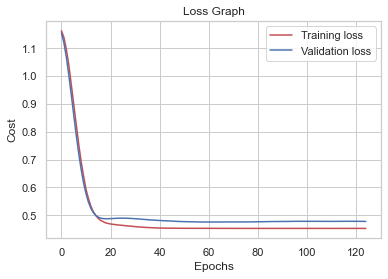

AUC 0.8423939256669664
Specificity: 0.8529243113994165
Sensitivity: 0.6013350381911255
Positive Predictive Value: 0.6907401277371402
Negative Predictive Value: 0.7944382742240916
Best Model ROC: 


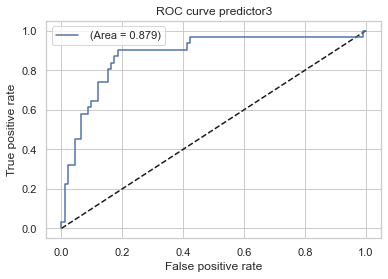

In [158]:
simplePred, aucPred, spePred, senPred, ppvPred, npvPred = cross_val('predictor')

## Limpiando Datos
#### Reemplazando Nulls por la mediana

Trial 30 Complete [00h 00m 10s]
val_loss: 0.9334154923756918

Best val_loss So Far: 0.4832799732685089
Total elapsed time: 00h 03m 46s
INFO:tensorflow:Oracle triggered exit


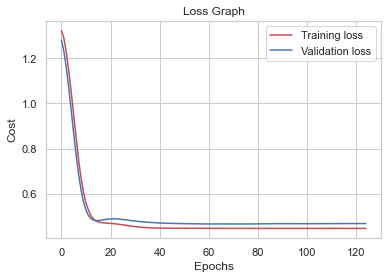

AUC 0.8456786237943789
Specificity: 0.8630555308385613
Sensitivity: 0.598804993928473
Positive Predictive Value: 0.7107634144531401
Negative Predictive Value: 0.7962225696136983
Best Model ROC: 


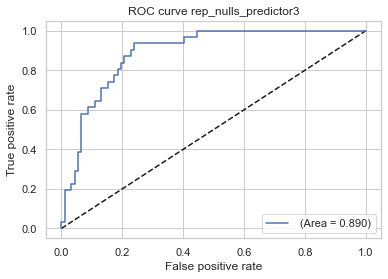

In [159]:
repNullsPred, aucrepNull, sperepNull, senrepNull, ppvrepNull, npvrepNull = cross_val('rep_nulls_predictor',replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])

#### Reemplazando Outliers


Trial 30 Complete [00h 00m 10s]
val_loss: 0.9337597886721293

Best val_loss So Far: 0.4762144088745117
Total elapsed time: 00h 03m 16s
INFO:tensorflow:Oracle triggered exit


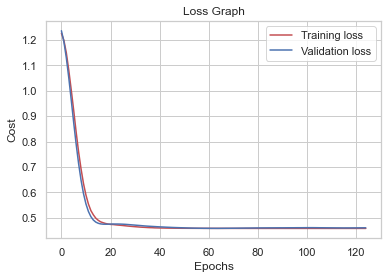

AUC 0.83998704137251
Specificity: 0.8647529697861479
Sensitivity: 0.6091781754306489
Positive Predictive Value: 0.708259309260806
Negative Predictive Value: 0.8010849461095972
Best Model ROC: 


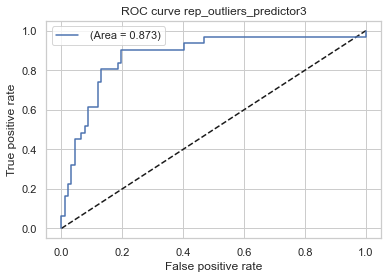

In [160]:
repOutPred, aucrepOut, sperepOut, senrepOut, ppvrepOut, npvrepOut = cross_val('rep_outliers_predictor', replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]})

#### Reemplazando Outliers y nulls


Trial 30 Complete [00h 00m 11s]
val_loss: 0.9484410683314005

Best val_loss So Far: 0.4770503540833791
Total elapsed time: 00h 03m 23s
INFO:tensorflow:Oracle triggered exit


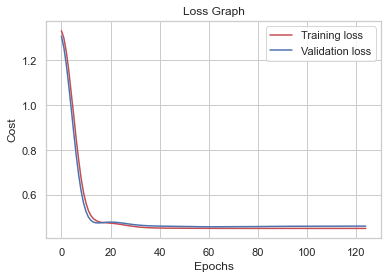

AUC 0.8455917294547632
Specificity: 0.8706762092371985
Sensitivity: 0.5998834252962114
Positive Predictive Value: 0.7220736051355855
Negative Predictive Value: 0.797955754152188
Best Model ROC: 


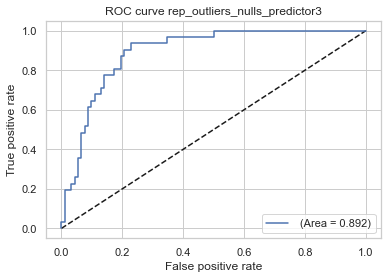

In [161]:
repOutNullPred, aucrepOutNull, sperepOutNull, senrepOutNull, ppvrepOutNull, npvrepOutNull = cross_val('rep_outliers_nulls_predictor',replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]})



Comparando los resultados anteriores:
- AUC reemplazando nulls: 0.8456786237943789
- AUC reemplazando outliers y nulls: 0.8455917294547632
- AUC reemplazando outliers: 0.83998704137251

Dado que el valor más alto es reemplazando nulls, continuamos el análisis con este parámetro.

#### Removiendo Columnas

Trial 30 Complete [00h 00m 12s]
val_loss: 0.9373034437497457

Best val_loss So Far: 0.4653705557187398
Total elapsed time: 00h 03m 37s
INFO:tensorflow:Oracle triggered exit


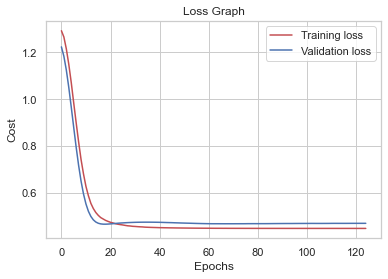

AUC 0.851044953347263
Specificity: 0.8569436634253883
Sensitivity: 0.6128261462312458
Positive Predictive Value: 0.694738798971822
Negative Predictive Value: 0.8013249746226017
Best Model ROC: 


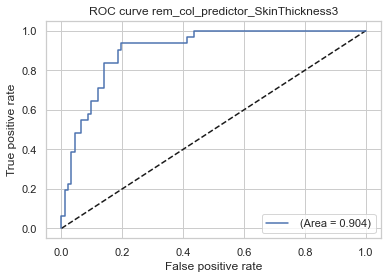

In [162]:
bestAuc = aucrepNull
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeCols = []
removeColsAuc = []
nullCols = ['Glucose','BloodPressure','SkinThickness','BMI']	
		
for col in tryRemovingCols:
	print(col)	
	remColPred, aucremCol, speremCol, senremCol, ppvremCol, npvremCol = cross_val('rem_col_predictor_' + col ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], columnsToRemove=[col])
	if (aucremCol > bestAuc):
		removeCols.append(col)
		removeColsAuc.append(aucremCol)


In [163]:
print(removeCols)
print(removeColsAuc)

['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'SkinThickness']
[0.8474895240499787, 0.8546454609589604, 0.8458452785789289, 0.851044953347263]


#### Eliminando todas las columnas que superaron el valor anterior.

Trial 30 Complete [00h 00m 17s]
val_loss: 1.025095025698344

Best val_loss So Far: 0.4675523539384206
Total elapsed time: 00h 05m 55s
INFO:tensorflow:Oracle triggered exit


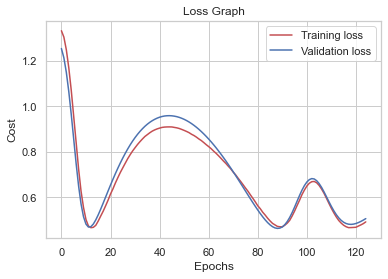

AUC 0.8517524559481208
Specificity: 0.8625736916845238
Sensitivity: 0.6341781753681488
Positive Predictive Value: 0.710360813279334
Negative Predictive Value: 0.8108121281748627
Best Model ROC: 


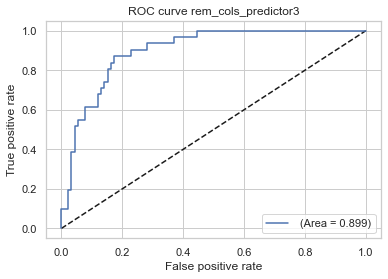

In [164]:
remColsPred, aucremCols, speremCols, senremCols, ppvremCols, npvremCols = cross_val('rem_cols_predictor' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], columnsToRemove=removeCols)

#### Sacando solo SkinThickness  y Age

Trial 30 Complete [00h 00m 13s]
val_loss: 1.106959342956543

Best val_loss So Far: 0.46989856163660687
Total elapsed time: 00h 04m 58s
INFO:tensorflow:Oracle triggered exit


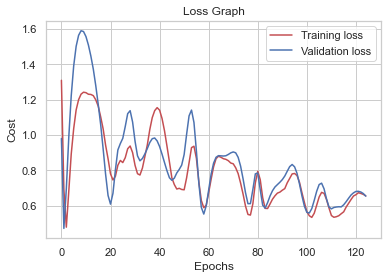

AUC 0.8512676664943841
Specificity: 0.8660849228569447
Sensitivity: 0.6145589323706493
Positive Predictive Value: 0.7146029985910678
Negative Predictive Value: 0.8028938436180534
Best Model ROC: 


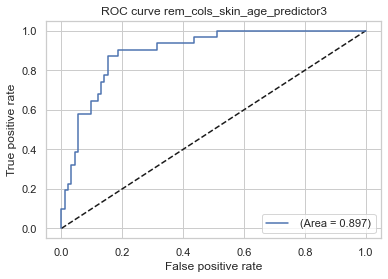

In [165]:
remColsCombPred, aucremColsComb, speremColsComb, senremColsComb, ppvremColsComb, npvremColsComb = cross_val('rem_cols_skin_age_predictor' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], columnsToRemove=['SkinThickness', 'Age'])


AUC:
- Eliminando Age: 0.8546454609589604
- Eliminando 'Glucose','BloodPressure','SkinThickness','BMI': 0.8517524559481208
- Eliminando SkinThickness y Age: 0.8512676664943841
- Eliminando SkinThickness: 851044953347263
- Eliminando BloodPressure: 0.8474895240499787
- Eliminando DiabetesPedigreeFunction: 0.8458452785789289
- Sin eliminar columnas: 0.8456786237943789

Procedemos eliminando la columna de Age

### Con PolynomialFeatures

Trial 30 Complete [00h 00m 12s]
val_loss: 0.6230027476946512

Best val_loss So Far: 0.5441664258639017
Total elapsed time: 00h 04m 46s
INFO:tensorflow:Oracle triggered exit


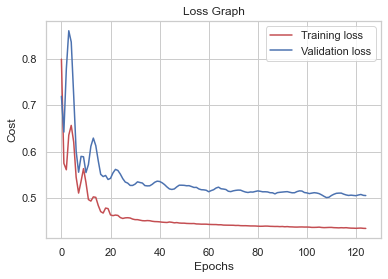

AUC 0.8411461263733123
Specificity: 0.8829737786338357
Sensitivity: 0.5741652310972836
Positive Predictive Value: 0.7215694333342821
Negative Predictive Value: 0.7907265980613642
Best Model ROC: 


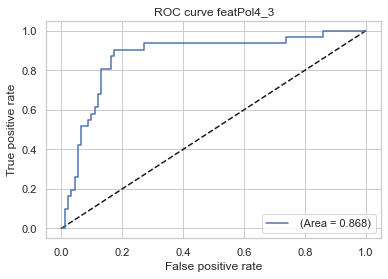

In [167]:
aucPolys = []
for i in range(1,5):
    print(i)
    polyPred, aucPoly, spePoly, senPoly, ppvPoly, npvPoly = cross_val('featPol' + str(i) + '_' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], columnsToRemove=['Age'], polyFeatDeg=i)
    aucPolys.append(aucPoly)

bestPolDeg = aucPolys.index(max(aucPolys)) + 1


In [168]:
print(aucPolys)

[0.8524169324051533, 0.8556428962379096, 0.8458287639337619, 0.8411461263733123]


In [169]:
print('Best Degree: ' + str(bestPolDeg) + " --- AUC: " + str(max(aucPolys)))

Best Degree: 2 --- AUC: 0.8556428962379096


#### Con EarlyStopping

In [ ]:
earlyPred = DiabetesPredictor('earlyPred')
earlyPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = True)

#### Con DropOut

In [ ]:
dropPred = DiabetesPredictor('dropPred')
dropPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = False, dropOut = True)

#### Con Regularizadores

In [ ]:
def reg_wrapper(type, value):
    if type == 'l2':
        return regularizers.l2(value)
    if type == 'l1':
        return regularizers.l1(value)

In [ ]:
reguPred = DiabetesPredictor('reguPred')
reguPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = False, regu = True)

In [ ]:
reguPred.best_hps.values

#### Con Batch Normalization

In [ ]:
batchPred = DiabetesPredictor('batchPred')
batchPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = False, batchNormalization = True)